In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
num_subjects = 3
num_electrodes = 15
k_values = range(1, 11)
bands = ['Mu', 'Beta']
classes = [1, 2]

In [4]:
def load_relative_change_data(subject, band, trial_class):
    file_path = f"../data/processed/subject_{subject}/Subject{subject}_{band}_Band_Class{trial_class}_Relative_Change.csv"
    return pd.read_csv(file_path)

In [5]:
def evaluate_knn(X, y, k):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    errors = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)
        errors.append(error)

    return np.mean(errors)

In [6]:
results = {
    'subject': [],
    'electrode': [],
    'band': [],
    'k': [],
    'error': []
}

for subject in range(1, num_subjects + 1):
    for electrode in range(num_electrodes):
        for band in bands:
            class1_data = load_relative_change_data(subject, band, classes[0]).iloc[:, electrode]
            class2_data = load_relative_change_data(subject, band, classes[1]).iloc[:, electrode]

            X = np.concatenate([class1_data, class2_data]).reshape(-1, 1)
            y = np.array([1] * len(class1_data) + [2] * len(class2_data))

            for k in k_values:
                error = evaluate_knn(X, y, k)
                results['subject'].append(subject)
                results['electrode'].append(electrode)
                results['band'].append(band)
                results['k'].append(k)
                results['error'].append(error)

In [8]:
results_df = pd.DataFrame(results)

results_df.to_csv("../data/results/knn_results.csv", index=False)

best_results = results_df.loc[results_df.groupby('subject')['error'].idxmin()]

best_results.to_csv("../data/results/best_knn_results.csv", index=False)

In [16]:
for subject in range(1, num_subjects + 1):
    subject_results = best_results[best_results['subject'] == subject]
    average_best = subject_results.groupby(['electrode', 'band', 'k']).mean().reset_index()
    best_average_result = average_best.loc[average_best['error'].idxmin()]

    print(f"Subject {subject}:")
    print(f"Best electrode: {best_average_result['electrode']}")
    print(f"Best band: {best_average_result['band']}")
    print(f"Best K: {best_average_result['k']}")
    print(f"Least error achieved: {best_average_result['error']}\n")

Subject 1:
Best electrode: 3
Best band: Beta
Best K: 2
Least error achieved: 0.2

Subject 2:
Best electrode: 0
Best band: Beta
Best K: 2
Least error achieved: 0.1

Subject 3:
Best electrode: 4
Best band: Beta
Best K: 4
Least error achieved: 0.2



In [10]:
average_best = best_results.groupby(['electrode', 'band', 'k']).mean().reset_index()
best_average_result = average_best.loc[average_best['error'].idxmin()]

print(f"Best electrode, band, and K across subjects: Electrode {best_average_result['electrode']}, Band {best_average_result['band']}, K {best_average_result['k']}")
print(f"Least error achieved: {best_average_result['error']}")

Best electrode, band, and K across subjects: Electrode 0, Band Beta, K 2
Least error achieved: 0.1


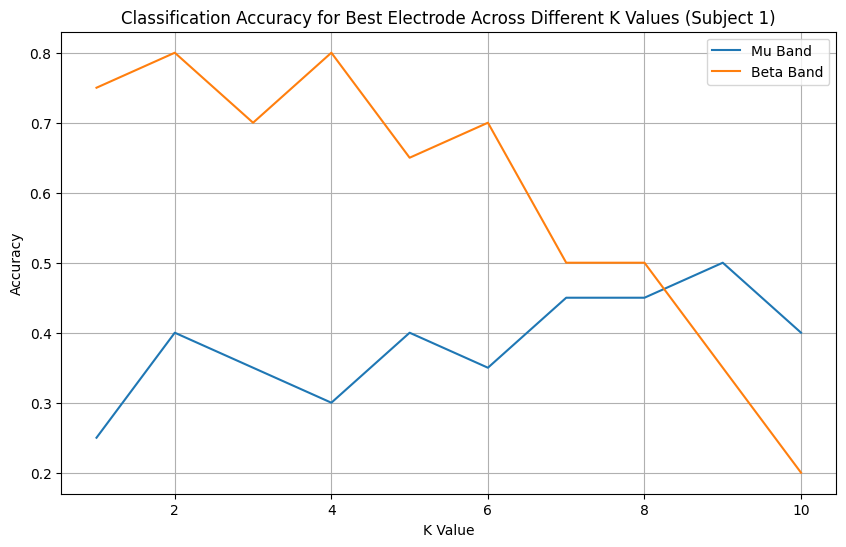

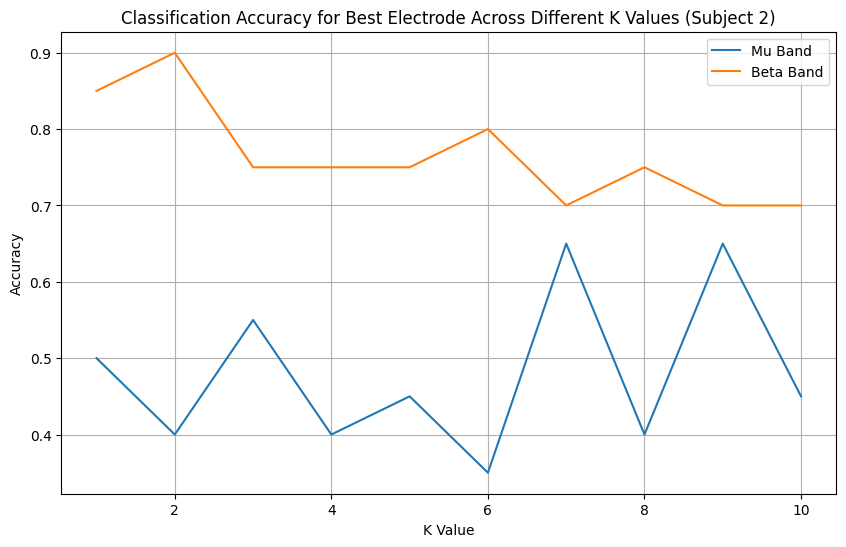

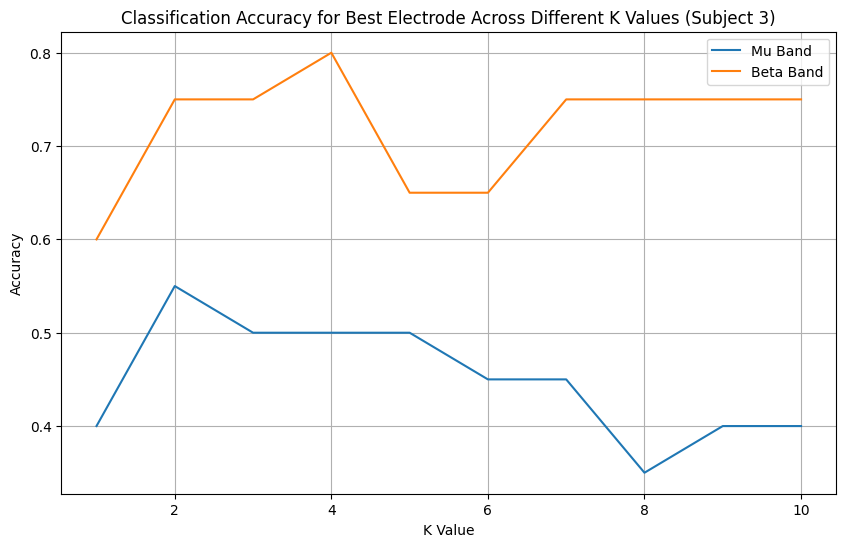

In [11]:
for subject in range(1, num_subjects + 1):
    subject_results = results_df[results_df['subject'] == subject]
    best_electrode = best_results[best_results['subject'] == subject]['electrode'].values[0]

    plt.figure(figsize=(10, 6))
    plt.title(f"Classification Accuracy for Best Electrode Across Different K Values (Subject {subject})")
    
    for band in bands:
        band_results = subject_results[(subject_results['electrode'] == best_electrode) & (subject_results['band'] == band)]
        plt.plot(band_results['k'], 1 - band_results['error'], label=f'{band} Band')
    
    plt.xlabel('K Value')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# Load concatenated data for each subject
concat_results = []
for subject in range(1, num_subjects + 1):
    X_concat = []
    for band in bands:
        for electrode in range(num_electrodes):
            class1_data = load_relative_change_data(subject, band, classes[0]).iloc[:, electrode]
            class2_data = load_relative_change_data(subject, band, classes[1]).iloc[:, electrode]
            X_concat.append(np.concatenate([class1_data, class2_data]).reshape(-1, 1))

    X_concat = np.hstack(X_concat)
    y_concat = np.array([1] * len(class1_data) + [2] * len(class2_data))

    # Evaluate KNN for concatenated data
    concat_subject_results = []
    for k in k_values:
        error = evaluate_knn(X_concat, y_concat, k)
        concat_subject_results.append((subject, k, error))

    concat_results.extend(concat_subject_results)

In [13]:
concat_results_df = pd.DataFrame(concat_results, columns=['subject', 'k', 'error'])

concat_results_df.to_csv("../data/results/concat_knn_results.csv", index=False)

best_concat_results = concat_results_df.loc[concat_results_df.groupby('subject')['error'].idxmin()]

best_concat_results.to_csv("../data/results/best_concat_knn_results.csv", index=False)

for subject in range(1, num_subjects + 1):
    best_result = best_concat_results[best_concat_results['subject'] == subject]
    print(f"Subject {subject}: Best K = {best_result['k'].values[0]}, Error = {best_result['error'].values[0]}")

average_best_concat = best_concat_results.mean()
print(f"Average best K for concatenated data: {average_best_concat['k']}")
print(f"Average least error for concatenated data: {average_best_concat['error']}")

Subject 1: Best K = 3, Error = 0.5
Subject 2: Best K = 3, Error = 0.25
Subject 3: Best K = 9, Error = 0.5
Average best K for concatenated data: 5.0
Average least error for concatenated data: 0.4166666666666667


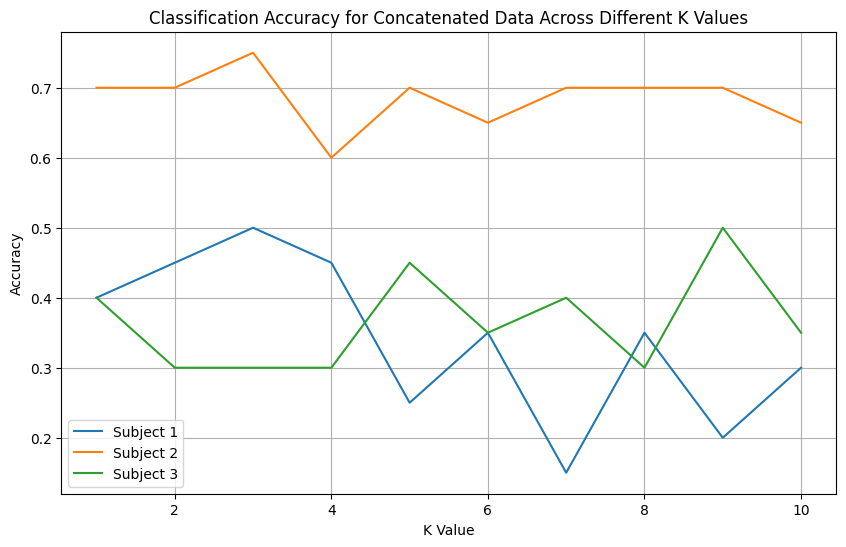

In [15]:
# Plot accuracy across different K values for concatenated data
plt.figure(figsize=(10, 6))
plt.title(f"Classification Accuracy for Concatenated Data Across Different K Values")

for subject in range(1, num_subjects + 1):
    subject_results = concat_results_df[concat_results_df['subject'] == subject]
    plt.plot(subject_results['k'], 1 - subject_results['error'], label=f'Subject {subject}')

plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
